**Downloading the dataset**

In [ ]:
!git clone https://github.com/ursaj123/Animal10-in-Pytorch

Cloning into 'BasicCNN_Pytorch'...
remote: Enumerating objects: 26240, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 26240 (delta 11), reused 40 (delta 6), pack-reused 26195
Receiving objects: 100% (26240/26240), 604.70 MiB | 24.36 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (26200/26200), done.


**Importing the libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

In [ ]:
import torch
import torch.nn as nn   # for creating models
from time import time
import torchvision 
import torchvision.transforms as transforms # for preprocessing image i.e., converting image to tensor and taking random crops of images, tilting it some angle and flipping it horizontally

from torchsummary import summary

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cuda


**DEFINING DATASETS AND DATALOADERS**

In [ ]:
dataset_path = '/content/BasicCNN_Pytorch/raw-img'
# mean and std are to normalize 
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32) # mean and std are mean and std of images over the three channels
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

# preprocessing 
transform = transforms.Compose([  # creating a object transform so that we can pass each image through this object
    # flipping
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=40),
    # taking the crops and resizing the image
    transforms.Resize(300),
    transforms.CenterCrop(256),
    # converting the mage to tensors
    transforms.ToTensor(),
    # normalizing the data sppeds up the training phase
    transforms.Normalize(mean=mean, std=std) 
])

# Create a dataset by applying the above transformation.
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
# splitting the dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (21000,5179))

# creating a training and test dataloaders, so that images come into batches while training 
''' num_workers load the data already in the memory, when the main process requires next batch of data it loads data quickly, 
    this speeds up training. By default it is set to 0'''
train_dataloader = torch.utils.data.DataLoader(
             dataset = train_dataset,
             batch_size = 16,
             shuffle = False,  
             num_workers = 2
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

**DISPLAYING IMAGES**

In [ ]:
figsize = (16,16)

def PlotSamples(dataloader):  # prints the image of a batch in dataloader
  sample_data = next(iter(dataloader))[0].to(device)
  plt.figure(figsize=figsize)
  plt.axis('off')  # it is written not to print axis, instead it will make a white border around the images
  plt.title("IMAGES")
  plt.imshow(np.transpose(torchvision.utils.make_grid(
      sample_data, normalize = True 
  ).cpu(), (1,2,0))) # (1,2,0) is for first showing the images correctly


def PlotClass(dataloader, mclass, num = 16): # plots num images of the same class (mclass)
  sample_data = []
  for data in dataloader.dataset:
    if data[1]==mclass: # if data is from class 'mclass'
      sample_data.append(data[0])
    if len(sample_data)==num:
      break
  plt.figure(figsize = figsize)
  plt.axis('off')
  plt.title("Images of class "+str(mclass))
  plt.imshow(np.transpose(torchvision.utils.make_grid(
      sample_data, normalize=True
  ).cpu(), (1,2,0)))

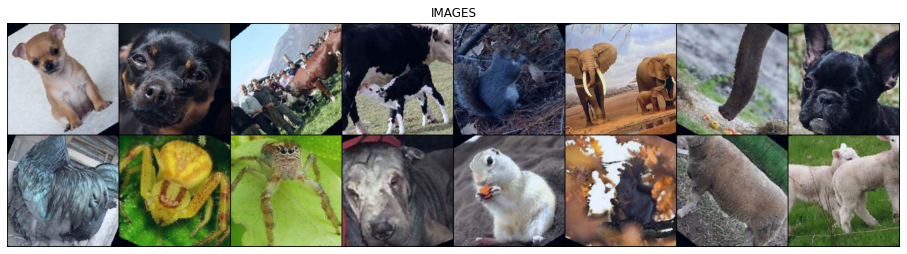

In [ ]:
PlotSamples(train_dataloader)

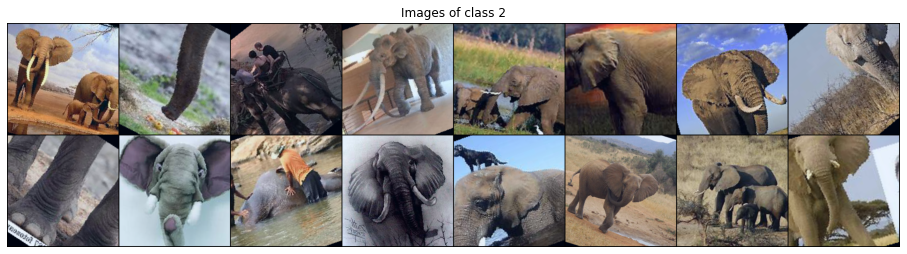

In [ ]:
PlotClass(train_dataloader, 2)

In [ ]:
'''# train_dataloader.dataset[i][0] represents ith image and train_dataloader.dataset[i][1] represents label of ith image in the batch
plt.imshow(np.transpose(torchvision.utils.make_grid(train_dataloader.dataset[1][0], normalize = True)))
plt.axis('off')
plt.title(train_dataloader.dataset[1][1])'''

"# train_dataloader.dataset[i][0] represents ith image and train_dataloader.dataset[i][1] represents label of ith image in the batch\nplt.imshow(np.transpose(torchvision.utils.make_grid(train_dataloader.dataset[1][0], normalize = True)))\nplt.axis('off')\nplt.title(train_dataloader.dataset[1][1])"

**DEFINING OUR MODEL**

In [ ]:
class Animal10(nn.Module):
    def __init__(self):
        super(Animal10, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4096, 256),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(256, 10)
        ).to(device)
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


model = Animal10().to(device)
summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
            Conv2d-3         [-1, 16, 252, 252]           2,320
              ReLU-4         [-1, 16, 252, 252]               0
         MaxPool2d-5         [-1, 16, 126, 126]               0
            Conv2d-6         [-1, 32, 124, 124]           4,640
              ReLU-7         [-1, 32, 124, 124]               0
            Conv2d-8         [-1, 32, 122, 122]           9,248
              ReLU-9         [-1, 32, 122, 122]               0
        MaxPool2d-10           [-1, 32, 61, 61]               0
           Conv2d-11           [-1, 64, 59, 59]          18,496
             ReLU-12           [-1, 64, 59, 59]               0
           Conv2d-13           [-1, 64, 57, 57]          36,928
             ReLU-14           [-1, 64,

In [ ]:
def train(epoch, print_every = 50):
  total_loss = 0
  start_time = time()
  
  accuracy = []

  for i,batch in enumerate(train_dataloader, 1):
    # taking inputs from the dataloader
    model_input = batch[0].to(device) # batch[0] are the images in the batch 
    target = batch[1].to(device) # batch[1] are the corresponding lables of the images in the batch 
    # passing the inputs defined above through our model and calculating the loss
    model_output = model(model_input)
    loss = criterion(model_output, target)
    total_loss+= loss.item()
    # now comes the backward propoagation
    optimizer.zero_grad()  # clears the gradient if any exist
    loss.backward()
    # updating model parameters
    optimizer.step()
    # predictions according to the model
    result = model_output.argmax(dim=1)  
    accuracy.append((result==target).sum().item()/target.shape[0])  # accuracy is number of images predicted correctly from a batch of images



    if i%print_every==0:   # print after 'print_every' no. of batches are loaded
      print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time # accuracy printed will be the average accuracy over all the batches
            ))  # the loss printed here will be the loss corresponding to the ith batch
  return total_loss/(len(train_dataloader))  # return average loss over all the batches

In [ ]:
def test(epoch):
  total_loss = 0
  start_time = time()
  accuracy = []

  with torch.no_grad(): # this disables calculation of gradients inside its indentation
    for i,batch in enumerate(test_dataloader):
      model_input = batch[0].to(device)
      target = batch[1].to(device)

      model_output = model(model_input)
      loss = criterion(model_output,target)
      total_loss+= loss.item()

      result = model_output.argmax(dim=1)
      accuracy.append((result==target).sum().item()/target.shape[0])
  print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
  return total_loss/len(test_dataloader) # Returning Average Testing Loss

In [ ]:
lr = 1e-4
model = Animal10().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loss = []
test_loss = []
for epoch in range(1,51):
  train_loss.append(train(epoch,200))  # print cost after 200 batches are passed
  test_loss.append(test(epoch))

  print('\n')

  if epoch%10==0:
    torch.save(model, 'model_'+str(epoch)+'.pth')

Epoch: [1]/(200/1313), Train Loss: 2.2591, Accuracy: 0.18, Time: 27.88 sec
Epoch: [1]/(400/1313), Train Loss: 1.9664, Accuracy: 0.18, Time: 54.94 sec
Epoch: [1]/(600/1313), Train Loss: 2.3634, Accuracy: 0.18, Time: 82.20 sec
Epoch: [1]/(800/1313), Train Loss: 2.3199, Accuracy: 0.19, Time: 109.53 sec
Epoch: [1]/(1000/1313), Train Loss: 2.3005, Accuracy: 0.20, Time: 139.19 sec
Epoch: [1]/(1200/1313), Train Loss: 2.0347, Accuracy: 0.21, Time: 167.53 sec
Epoch: [1], Test Loss: 2.1120, Accuracy: 0.25, Time: 37.91 sec


Epoch: [2]/(200/1313), Train Loss: 1.9476, Accuracy: 0.28, Time: 27.72 sec
Epoch: [2]/(400/1313), Train Loss: 1.7308, Accuracy: 0.29, Time: 54.66 sec
Epoch: [2]/(600/1313), Train Loss: 2.3606, Accuracy: 0.29, Time: 81.98 sec
Epoch: [2]/(800/1313), Train Loss: 2.1940, Accuracy: 0.30, Time: 109.28 sec
Epoch: [2]/(1000/1313), Train Loss: 2.2394, Accuracy: 0.30, Time: 139.48 sec
Epoch: [2]/(1200/1313), Train Loss: 1.7770, Accuracy: 0.31, Time: 168.61 sec
Epoch: [2], Test Loss: 1.

**PLOTTING THE TRAIN TEST LOSS CURVE**

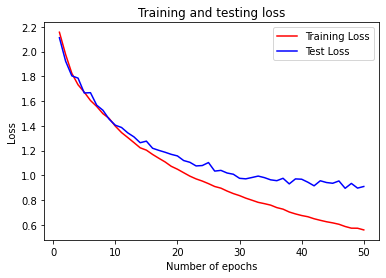

In [ ]:
plt.plot(range(1,len(train_loss)+1),train_loss, color = 'r', label = 'Training Loss')
plt.plot(range(1,len(test_loss)+1), test_loss, color = 'b', label = 'Test Loss')
plt.title("Training and testing loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**TEST ON RANDOM IMAGES**

In [ ]:
translate = {
    "cane": "dog", 
    "cavallo": "horse", 
    "elefante": "elephant", 
    "farfalla": "butterfly", 
    "gallina": "chicken", 
    "gatto": "cat", 
    "mucca": "cow", 
    "pecora": "sheep", 
    "ragno": "spider",
    "scoiattolo": "squirrel",
}

translate = {x:translate[x] for x in train_dataloader.dataset.dataset.classes}

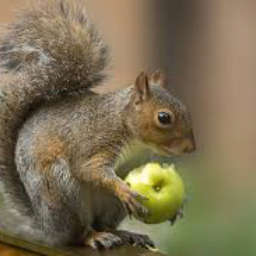

squirrel : 95 % 




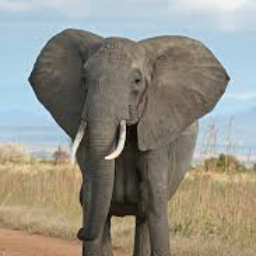

elephant : 99 % 




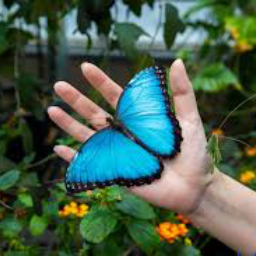

sheep : 39 % 




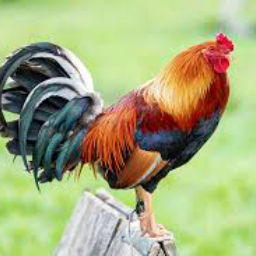

chicken : 99 % 




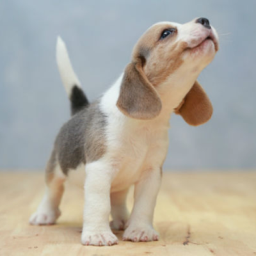

dog : 86 % 




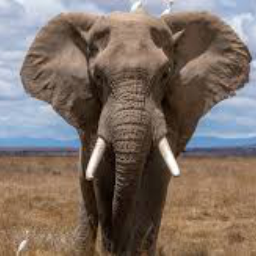

elephant : 99 % 




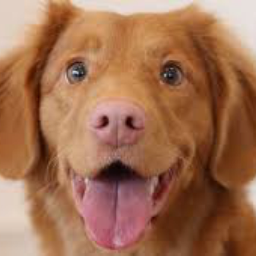

dog : 99 % 




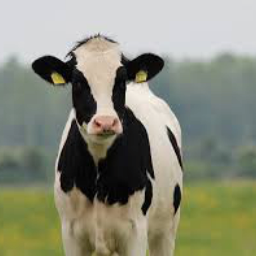

spider : 95 % 




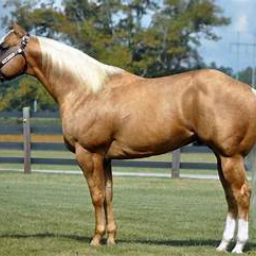

horse : 88 % 




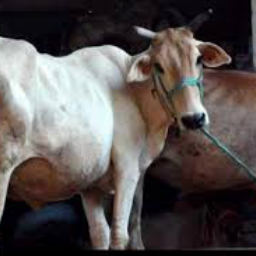

cow : 43 % 




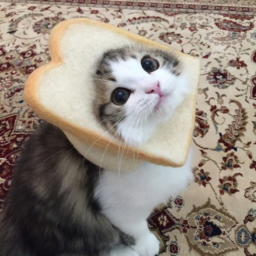

dog : 57 % 




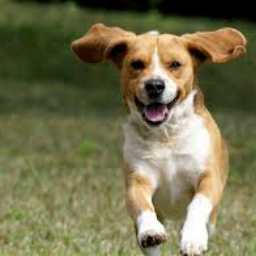

dog : 99 % 




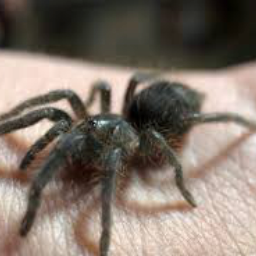

spider : 99 % 




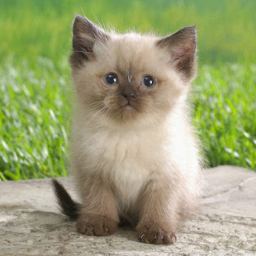

dog : 99 % 




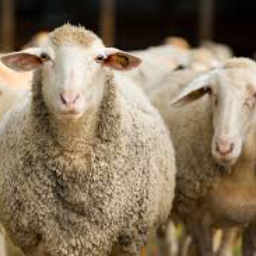

sheep : 96 % 




In [ ]:
# now comes the prediction time, we will predict on the basis of model_50
denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])


with torch.no_grad():

    for impath in os.listdir('BasicCNN_Pytorch/test_images/'):
        try:
            image = Image.open(f'BasicCNN_Pytorch/test_images/{impath}')
        except:
            continue

        image = transforms.Compose([
            transforms.Resize(256),  
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])(image)

        image_tensor = image.view(1,3,256,256).to(device)

        model_output = model(image_tensor)
        model_output = nn.Softmax(dim=1)(model_output)[0]*100
        
        idx = model_output.argmax().data.item()
        oclass = list(translate.keys())[idx]
        model_output = model_output.int().data.cpu().numpy()

        display(denormalize(image))
        print(translate[oclass], ':', model_output[idx], '%', '\n\n')

model.train()
pass

Clearly, the output isn't that good, so trying 50 more epochs

In [ ]:
model.train()

for epoch in range(51,101):
    train_loss.append(train(epoch,200))
    test_loss.append(test(epoch))

    print('\n')
    
    if epoch % 10 == 0:
        torch.save(model, 'model_'+str(epoch)+'.pth')

Epoch: [51]/(200/1313), Train Loss: 0.7290, Accuracy: 0.81, Time: 27.83 sec
Epoch: [51]/(400/1313), Train Loss: 0.3177, Accuracy: 0.81, Time: 55.36 sec
Epoch: [51]/(600/1313), Train Loss: 0.3095, Accuracy: 0.81, Time: 82.56 sec
Epoch: [51]/(800/1313), Train Loss: 0.6762, Accuracy: 0.81, Time: 109.93 sec
Epoch: [51]/(1000/1313), Train Loss: 0.5872, Accuracy: 0.81, Time: 139.64 sec
Epoch: [51]/(1200/1313), Train Loss: 0.4251, Accuracy: 0.81, Time: 168.57 sec
Epoch: [51], Test Loss: 0.9938, Accuracy: 0.71, Time: 37.96 sec


Epoch: [52]/(200/1313), Train Loss: 0.5023, Accuracy: 0.82, Time: 27.81 sec
Epoch: [52]/(400/1313), Train Loss: 0.2472, Accuracy: 0.82, Time: 55.94 sec
Epoch: [52]/(600/1313), Train Loss: 0.4734, Accuracy: 0.82, Time: 83.85 sec
Epoch: [52]/(800/1313), Train Loss: 0.4019, Accuracy: 0.82, Time: 112.04 sec
Epoch: [52]/(1000/1313), Train Loss: 0.5487, Accuracy: 0.82, Time: 143.54 sec
Epoch: [52]/(1200/1313), Train Loss: 0.3175, Accuracy: 0.82, Time: 173.90 sec
Epoch: [52],

**RUN TIME WAS DISCONNECTED BY GOOGLE, NOW GPU IS DISABLED. WELL ANYWAYS WE CAN SEE TRAIN ACCURACY IS 90% AND TEST ACCURACY IS 76%, SO THAT WILL ALSO DO QUITE WELL**

In [ ]:
denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])

with torch.no_grad():

    for impath in os.listdir('BasicCNN_Pytorch/test_images/'):
        try:
            image = Image.open(f'BasicCNN_Pytorch/test_images/{impath}')
        except:
            continue

        image = transforms.Compose([
            transforms.Resize(256),  
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])(image)

        image_tensor = image.view(1,3,256,256).to(device)

        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100
        
        idx = moutput.argmax().data.item()
        oclass = list(translate.keys())[idx]
        moutput = moutput.int().data.cpu().numpy()

        display(denormalize(image))
        print(translate[oclass], ':', moutput[idx], '%', '\n\n')

model.train()
pass